In [67]:
import pandas as pd
from pandas_datareader import data

import numpy as np, numpy.random
from numpy import mean

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

from datetime import datetime

from scipy.stats import norm 
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy import stats

from statsmodels.tsa.stattools import adfuller

from IPython.display import display, HTML

In [68]:
#Based loosely on https://towardsdatascience.com/how-to-simulate-financial-portfolios-with-python-d0dc4b52a278

def extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue,backtestduration=0):
    dim=len(symbols)
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]

    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(backtestduration+1):].values[0][0])
        
    noOfShares=[]
    portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeights]
    for i in range(0,len(symbols)):
        noOfShares.append(portfolioValPerSymbol[i]/priceAtEndDate[i])
    noOfShares=[round(element, 5) for element in noOfShares]
    listOfColumns=dfprices.columns.tolist()   
    dfprices["Adj Close Portfolio"]=dfprices[listOfColumns].mul(noOfShares).sum(1)
    
    share_split_table=dfprices.tail(1).T
    share_split_table=share_split_table.iloc[:-1]
    share_split_table["Share"]=symbols
    share_split_table["No Of Shares"]=noOfShares
    share_split_table.columns=["Price At "+end_date,"Share Name","No Of Shares"]
    share_split_table["Value At "+end_date]=share_split_table["No Of Shares"]*share_split_table["Price At "+end_date]
    share_split_table.index=share_split_table["Share Name"]
    share_split_table=share_split_table[["Share Name","Price At "+end_date,"No Of Shares","Value At "+end_date]]
    share_split_table=share_split_table.round(3)
    share_split_table=share_split_table.append(share_split_table.sum(numeric_only=True), ignore_index=True)
    share_split_table.at[len(symbols),'No Of Shares']=np.nan
    share_split_table.at[len(symbols),'Price At '+end_date]=np.nan
    share_split_table.at[len(symbols),'Share Name']="Portfolio"
    share_split_table["Weights"]=portfolioWeights+["1"]
    share_split_table = share_split_table[['Share Name', 'Weights', 'Price At '+end_date, 'No Of Shares', "Value At "+end_date]] 
    
    print(f"Extracted {len(dfprices)} days worth of data for {len(symbols)} counters with {dfprices.isnull().sum().sum()} missing data")
    
    return dfprices, noOfShares, share_split_table

In [69]:
def plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder):    
    labels = symbols
    sizes = portfolioWeights
    fig1, ax1 = plt.subplots()
    ax1.pie(portfolioWeights, labels=symbols, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Portfolio Weights")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_01portfolioweights.png')

In [70]:
def calc_returns(dfprices,symbols):
    dfreturns=pd.DataFrame()
    columns = list(dfprices) 
    mean=[]
    stdev=[]
    for column in columns:
        dfreturns[f'Log Daily Returns {column}']=np.log(dfprices[column]).diff()
        mean.append(dfreturns[f'Log Daily Returns {column}'][1:].mean())
        stdev.append(dfreturns[f'Log Daily Returns {column}'][1:].std())
    dfreturns=dfreturns.dropna()
    
    if len(dfreturns.columns)==1:
        df_mean_stdev=pd.DataFrame(list(zip(symbols,mean,stdev)),columns =['Stock', 'Mean Log Daily Return','StdDev Log Daily Return']) 
    else:
        df_mean_stdev=pd.DataFrame(list(zip(symbols+["Portfolio"],mean,stdev)),columns =['Stock', 'Mean Log Daily Return','StdDev Log Daily Return'])
    
    return dfreturns ,df_mean_stdev



In [5]:
def compareStartMidEnd(dfreturns,df_mean_stdev):

    #print ('Size of dataFrame=', len(dfreturns.index))
    desired_number_of_groups = 3
    group_size = int(len(dfreturns.index) / (desired_number_of_groups))
    #print("group_size=", group_size)
    remainder_size = len(dfreturns.index) % group_size
    #print("remainder_size=", remainder_size)
    df_split_list = [dfreturns.iloc[i:i + group_size] for i in range(0, len(dfreturns) - group_size + 1, group_size)]
    #print("Number of split_dataframes=", len(df_split_list))
    if remainder_size > 0:
        df_remainder = dfreturns.iloc[-remainder_size:len(dfreturns.index)]
        df_split_list.append(df_remainder)
    #print("Revised Number of split_dataframes=", len(df_split_list))
    #print("Splitting complete, verifying counts")

    count_all_rows_after_split = 0
    for index, split_df in enumerate(df_split_list):
        #print("split_df:", index, " size=", len(split_df.index))
        count_all_rows_after_split += len(split_df.index)

    if count_all_rows_after_split != len(dfreturns.index):
        raise Exception('rows_after_split = ', count_all_rows_after_split," but original CSV DataFrame has count =", len(dfreturns.index))

    columns =['Stock','Start Mean', 'Start StdDev','Middle Mean','Middle StdDev','End Mean','End StdDev']
    
    anothertable=[]
    for i in range(0,len(dfreturns.columns)):
        boxplotsplit=pd.DataFrame()
        boxplotsplit["Start"]=df_split_list[0].iloc[:,i].values
        boxplotsplit["Middle"]=df_split_list[1].iloc[:,i].values
        boxplotsplit["End"]=df_split_list[2].iloc[:,i].values
        #means = [boxplotsplit["Start"].mean(),boxplotsplit["Middle"].mean(),boxplotsplit["End"].mean()]
        #std =  [boxplotsplit["Start"].std(),boxplotsplit["Middle"].std(),boxplotsplit["End"].std()]
        meanstdev=[dfreturns.columns[i],boxplotsplit["Start"].mean(),boxplotsplit["Start"].std(),\
                   boxplotsplit["Middle"].mean(),boxplotsplit["Middle"].std(),\
                   boxplotsplit["End"].mean(),boxplotsplit["End"].std()]
        
        anothertable.append(meanstdev) 
        
    yetanothertable=pd.DataFrame(anothertable,columns=columns)
    
    yetanothertable["Overall Mean"]=df_mean_stdev["Mean Log Daily Return"]
    yetanothertable["Overall StdDev"]=df_mean_stdev["StdDev Log Daily Return"]
    yetanothertable=yetanothertable[['Stock','Overall Mean', 'Start Mean','Middle Mean','End Mean',\
                                     'Overall StdDev','Start StdDev','Middle StdDev','End StdDev']]
    
    return yetanothertable
        

In [6]:
def fit_test_normal(dfreturns,symbols,imagecounter,targetfolder):
    
    columnlist=dfreturns.columns
    KSTestResults=[]
    KSPValResults=[]
    for column in columnlist:
        data=(dfreturns[column])
        normed_data=(data-dfreturns[column].mean())/dfreturns[column].std()
        KSTestResults.append(kstest(normed_data, 'norm')[0])
        KSPValResults.append(kstest(normed_data, 'norm')[1])
    if len(dfreturns.columns)==1:
        KSTestResultsDF=pd.DataFrame([dfreturns.columns,KSTestResults,KSPValResults]).T
    else:
        KSTestResultsDF=pd.DataFrame([dfreturns.columns,KSTestResults,KSPValResults]).T
    KSTestResultsDF.columns=["Share Name","KS Test Statistic","KS Test P-Value"]
    KSTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(KSTestResultsDF['KS Test P-Value']> 0.05, "Data looks normal (Fail to reject H0)", "Data does NOT look normal (Reject H0)")
    
    ShapiroWilkTestStats=[]
    ShapiroWilkTestPValue=[]
    for column in columnlist:
        data=(dfreturns[column])
        stat, pvalue = shapiro(data)
        ShapiroWilkTestStats.append(stat)
        ShapiroWilkTestPValue.append(round(pvalue,6))

    ShapiroWilkTestResultsDF=pd.DataFrame([ShapiroWilkTestStats,ShapiroWilkTestPValue]).T
    if len(dfreturns.columns)==1:
        ShapiroWilkTestResultsDF["Share Name"]=dfreturns.columns
    else:
        ShapiroWilkTestResultsDF["Share Name"]=dfreturns.columns
    ShapiroWilkTestResultsDF.columns=["SW Test Statistic","SW Test P-Value","Share Name"]
    ShapiroWilkTestResultsDF=ShapiroWilkTestResultsDF[["Share Name","SW Test Statistic","SW Test P-Value"]]
    ShapiroWilkTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(ShapiroWilkTestResultsDF['SW Test P-Value']> 0.05, "Data looks normal (Fail to reject H0)", "Data does NOT look normal (Reject H0)")

    
    ADFTestStats=[]
    ADFTestCritValue=[]
    for column in columnlist:
        data=(dfreturns[column])        
        ADFTest_result = adfuller(data)
        ADFTestStats.append(ADFTest_result[0])
        ADFTestCritValue.append(ADFTest_result[4]['5%'])

    ADFTestResultsDF=pd.DataFrame([ADFTestStats,ADFTestCritValue]).T
    ADFTestResultsDF["Share Name"]=dfreturns.columns
    ADFTestResultsDF.columns=["ADF Test Statistic","ADF Test Stat Crit Value At 5% Signif Lvl","Share Name"]
    ADFTestResultsDF=ADFTestResultsDF[["Share Name","ADF Test Statistic","ADF Test Stat Crit Value At 5% Signif Lvl"]]
    ADFTestResultsDF["Accept/Reject At 5% Signif Lvl"]=np.where(ADFTestResultsDF['ADF Test Statistic']> ADFTestResultsDF['ADF Test Stat Crit Value At 5% Signif Lvl'] , "Time series is NON-stationary (Reject H0)", "Time series is stationary (Fail To Reject H0)")  
        
    skewArray=[]
    kurtosisArray=[]
    for column in columnlist:
        data=(dfreturns[column])
        skewArray.append(skew(data))
        kurtosisArray.append(kurtosis(data))
        mu = np.mean(data)
        sigma = np.std(data)
        plt.figure(figsize = (15, 5))
        plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        plt.plot(x, p, 'k', linewidth=2)
        title = column+" Histogram vs Best Fit Normal Distribution Mu = %.3f,  Sigma = %.3f" % (mu, sigma)
        plt.title(title)
        plt.savefig(f'static/{targetfolder}/{imagecounter}_04histogram{column}.png')
    
    Kurtosis_Skew=pd.DataFrame(list(zip(skewArray, kurtosisArray)), 
               index=columnlist,columns =['Skew','Kurtosis']) 
    
#     If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
#     If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed.
#     If the skewness is less than -1 or greater than 1, the data are highly skewed.
    def skewconditions(s):
        if (s['Skew'] > 1) :
            return "Highly Positively Skewed"
        elif (s['Skew'] <= 1) and (s['Skew'] > 0.5) :
            return "Moderately Positively Skewed"
        elif (s['Skew'] <= 0.5) and (s['Skew'] > -0.5) :
            return "Fairly Symmetrical"
        elif (s['Skew'] <= -0.5) and (s['Skew'] > -1.0) :
            return "Moderately Negatively Skewed"
        elif (s['Skew'] <= -1.0) :
            return "Highly Negatively Skewed"
    
#     For kurtosis, the general guideline is that if the number is greater than +1, the distribution is too peaked. 
#     Likewise, a kurtosis of less than –1 indicates a distribution that is too flat
    def kurtosisconditions(s):
        if (s['Kurtosis'] > 3) :
            return "Leptokurtic:Peaked & Fat Tailed"
        elif (s['Kurtosis'] <-3):
            return "Platykurtic:Flat & Thin Tailed"
        else :
            return "Mesokurtic"
    
    Kurtosis_Skew['Skew Description'] = Kurtosis_Skew.apply(skewconditions, axis=1)
    Kurtosis_Skew['Kurtosis Description'] = Kurtosis_Skew.apply(kurtosisconditions, axis=1)
    
    for i in range(0,len(columnlist)):
        data=(dfreturns.iloc[:, i])
        res = stats.probplot(data, dist="norm")
        xxx=pd.DataFrame(list(zip(res[0][0],res[0][1])),columns =["Theoretical Quantiles","Ordered Values"]) 
        xxx.plot.scatter(x="Theoretical Quantiles",y="Ordered Values",title=columnlist[i],figsize = (7.5, 5))
        plt.plot(xxx["Theoretical Quantiles"], res[1][0]*xxx["Theoretical Quantiles"]+res[1][1])
        plt.savefig(f'static/{targetfolder}/{imagecounter}_05qqplot{i}.png')
    
    return KSTestResultsDF, ShapiroWilkTestResultsDF, Kurtosis_Skew, ADFTestResultsDF

In [7]:
def bootstrap_w_replc_singleval(dfreturns):
    columns=dfreturns.columns
    singlesample=pd.DataFrame(dfreturns.values[np.random.randint(len(dfreturns), size=1)], columns=columns)
    return singlesample

def bootstrapforecast(dfreturns,T):
    columnlist=dfreturns.columns
    X=[]
    for i in range(0,T):
        X.append(bootstrap_w_replc_singleval(dfreturns).values.tolist()[0])
    Y=pd.DataFrame(X)
    Y.columns=columnlist
    Y.loc[-1] = [0]*len(columnlist)  # adding a row
    Y.index = Y.index + 1  # shifting index
    Y = Y.sort_index()  # sorting by index
    
    return Y


In [8]:
#Adapted from https://stackoverflow.com/questions/10939213/how-can-i-calculate-the-nearest-positive-semi-definite-matrix

#import numpy as np,numpy.linalg

def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

def create_covar(dfreturns):  
    try:
        returns=[]
        arrOfReturns=[]
        columns = list(dfreturns)
        for column in columns:
            returns=dfreturns[column].values.tolist()
            arrOfReturns.append(returns)
        Cov = np.cov(np.array(arrOfReturns))    
        return Cov
    except LinAlgError :
        Cov = nearPD(np.array(arrOfReturns), nit=10)
        print("WARNING -Original Covariance Matrix is NOT Positive Semi Definite And Has Been Adjusted To Allow For Cholesky Decomposition ")
        return Cov

In [9]:
def GBMsimulatorUniVar(So, mu, sigma, T, N):
    """
    Parameters

    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    #np.random.seed(seed) turned off so Monte Carlo can be "randomised"
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = sigma* Z * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

def GBMsimulatorMultiVar(So, mu, sigma, Cov, T, N):
    """
    Parameters

    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    #np.random.seed(seed) turned off so Monte Carlo can be "randomised"
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

def calculateRMSE(final,T,backtest_duration,dfprices):
    xyz=final.tail(T)
    xyz=xyz.head(backtest_duration)
    xyz
    qrs=pd.DataFrame(index=xyz.index)
    for i in range(0,len(dfprices.columns)):
        x=1+(len(dfprices.columns)-i)*-3
        qrs["Actual "+dfprices.columns[i]]=xyz.iloc[:,i]
        qrs["P50 "+dfprices.columns[i]]=xyz.iloc[:,x]
    for i in range(0,len(dfprices.columns)):
        x=i*2
        qrs["RMSE "+dfprices.columns[i]]=(qrs.iloc[:,x]-qrs.iloc[:,x+1])**2
    qrs
    RMSE=[]

    for i in range(0,len(dfprices.columns)):
        z=-(len(dfprices.columns)-i)
        RMSE.append((qrs.iloc[:,z].mean())**0.5)
    RMSE_DF=pd.DataFrame(RMSE,index=[dfprices.columns],columns=["RMSE For Backtest From "+qrs.index[0].strftime("%Y-%m-%d")+" To "+qrs.index[-1].strftime("%Y-%m-%d")\
                                                               +" ("+str(len(qrs))+" Days)"])
    return RMSE_DF

In [10]:
def MonteCarlo_GBM(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,imagecounter,targetfolder):
    
    forecastresults=pd.DataFrame()
    percentiles=pd.DataFrame()
    
    extended_dates_future=[]
    lowerpercentile=int(percentile_range[1:3])
    upperpercentile=int(percentile_range[5:7])
 
    plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder)

    if len(symbols)==1:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
        
    else:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
                  
    symbolsWPortfolio=symbols+["Portfolio"]

    dfreturns ,df_mean_stdev = calc_returns(dfprices,symbolsWPortfolio)
    
    S0=np.array(dfprices.tail(1).values.tolist()[0])
    mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
    sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())   

    backtestdateslist=(list((dfpricesFULL.tail(backtest_duration+1).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))
    
    for i in range(0,N-backtest_duration):
        extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
        
    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future
     
    if len(symbols)==1:
        for x in range(1,NoOfIterationsMC+1):
            stocks, time = GBMsimulatorUniVar(S0, mu, sigma, T, N)
            prediction=pd.DataFrame(stocks)
            prediction=prediction.T
            prediction.index=extended_dates
            prediction.columns=dfprices.columns
            prediction=prediction.add_prefix('Iter_'+str(x)+'_')
            forecastresults=pd.concat([forecastresults, prediction], axis=1)
        
        for x in range(1,NoOfIterationsMC+1):
            forecastresults["Iter_"+str(x)+"_Adj Close Portfolio"]=forecastresults["Iter_"+str(x)+"_Adj Close "+symbols[0]]*noOfSharesFULL

    else:
        Cov=create_covar(dfreturns)
        for x in range(1,NoOfIterationsMC+1):
            stocks, time = GBMsimulatorMultiVar(S0, mu, sigma, Cov, T, N)
            prediction=pd.DataFrame(stocks)
            prediction=prediction.T
            prediction.index=extended_dates
            prediction.columns=dfprices.columns
            prediction=prediction.add_prefix('Iter_'+str(x)+'_')
            forecastresults=pd.concat([forecastresults, prediction], axis=1)

    for y in range(0,len(symbolsWPortfolio)):
        percentiles["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(lowerpercentile)/100,1)
        percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
        percentiles["P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(upperpercentile)/100,1)

        forecastresults=pd.concat([forecastresults,percentiles[["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y],"P50_"+symbolsWPortfolio[y],"P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]]], axis=1, sort=False)
    
    final=pd.concat([dfpricesFULL,forecastresults], axis=1, sort=False)
              
    for z in range(0,len(symbolsWPortfolio)):
        #final.filter(regex="Adj Close "+symbolsWPortfolio[z]).tail(60).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")

        final.filter(regex="Adj Close "+symbolsWPortfolio[z]).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_totaliterations{z}.png')
        
        percentileplot=pd.DataFrame()
        percentileplot=pd.concat([final["Adj Close "+symbolsWPortfolio[z]],final.filter(regex="P??_"+symbolsWPortfolio[z])], axis=1, sort=False)
        
        #percentileplot.tail(60).plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")        
        #Show full plot below 
            
        percentileplot.plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")
        plt.axvline(x=end_date,linestyle='dashed')
        if NoOfIterationsMC>0:
            plt.savefig(f'static/{targetfolder}/{imagecounter}_percentile{z}.png')
  
    ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
    HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3)) 
    HelperTable["Sym"]=HelperTable.index
    HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
    HelperTable=HelperTable.sort_values(['Sym'])
    ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values)    
           
    ReturnsAtForecastEndDate["Returns Based On GBM"]=round((ReturnsAtForecastEndDate.iloc[:, 1]/ReturnsAtForecastEndDate.iloc[:, 0]-1)*100,2)
    
    return final, share_split_tableFULL , dfreturns , df_mean_stdev , ReturnsAtForecastEndDate, dfprices

In [11]:
def MonteCarlo_Bootstrap(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,imagecounter,targetfolder):
    
    forecastresults=pd.DataFrame()
    percentiles=pd.DataFrame()
    
    extended_dates_future=[]
    lowerpercentile=int(percentile_range[1:3])
    upperpercentile=int(percentile_range[5:7])
    
    plotpiechart(symbols,portfolioWeights,imagecounter,targetfolder)

    if len(symbols)==1:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
        
    else:
        dfpricesFULL, noOfSharesFULL, share_split_tableFULL = extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue)
        backtest_end_date=dfpricesFULL.index[-(backtest_duration+1)].strftime("%Y-%m-%d")
        dfprices, noOfShares, share_split_table = extract_prices(start_date,backtest_end_date,symbols,portfolioWeights,portfolioValue)
        dfprices["Adj Close Portfolio"]=dfprices[list(dfprices.iloc[:,:-1].columns)].mul(noOfSharesFULL).sum(1)
               
    symbolsWPortfolio=symbols+["Portfolio"]

    dfreturns ,df_mean_stdev = calc_returns(dfprices,symbolsWPortfolio)

    backtestdateslist=(list((dfpricesFULL.tail(backtest_duration+1).index)))
    backtestdates=[]
    for i in backtestdateslist:
        backtestdates.append(np.datetime64(datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d")))
        
    for i in range(0,N-backtest_duration):
        extended_dates_future.append(np.busday_offset(end_date, i, roll='forward'))
        
    extended_dates=backtestdates[0:len(backtestdates)-1]+extended_dates_future

    for x in range(1,NoOfIterationsMC+1):      
        
        futurereturns=bootstrapforecast(dfreturns,T)
        futurereturns=np.exp(futurereturns)
        futurereturns=futurereturns.cumprod()
        stocks=pd.DataFrame()
        for i in range(0,len(symbolsWPortfolio)):
            futurereturns[str(i)+"Price"]=(futurereturns.iloc[:, i])*dfprices.tail(1).iloc[:, i][0]
        stocks=futurereturns[futurereturns.columns[-len(symbolsWPortfolio):]] 
        stocks.columns=list(dfreturns.columns)

        prediction=stocks
        prediction.index=extended_dates
        prediction.columns=dfprices.columns
        prediction=prediction.add_prefix('Iter_'+str(x)+'_')
        forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
    
    for y in range(0,len(symbolsWPortfolio)):
        percentiles["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(lowerpercentile)/100,1)
        percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
        percentiles["P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(float(upperpercentile)/100,1)

        forecastresults=pd.concat([forecastresults,percentiles[["P"+str(lowerpercentile)+"_"+symbolsWPortfolio[y],"P50_"+symbolsWPortfolio[y],"P"+str(upperpercentile)+"_"+symbolsWPortfolio[y]]]], axis=1, sort=False)
    
    final=pd.concat([dfpricesFULL,forecastresults], axis=1, sort=False)
    
    for z in range(0,len(symbolsWPortfolio)):
        #final.filter(regex="Adj Close "+symbolsWPortfolio[z]).tail(60).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")

        final.filter(regex="Adj Close "+symbolsWPortfolio[z]).plot(legend=False,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+str(NoOfIterationsMC)+" Iter-s")
        plt.axvline(x=end_date,linestyle='dashed')
        plt.savefig(f'static/{targetfolder}/{imagecounter}_totaliterations{z}.png')
        
        percentileplot=pd.DataFrame()
        percentileplot=pd.concat([final["Adj Close "+symbolsWPortfolio[z]],final.filter(regex="P??_"+symbolsWPortfolio[z])], axis=1, sort=False)

        #percentileplot.tail(60).plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")
        #Show full plot below     
        percentileplot.plot(legend=True,figsize = (20, 5),title=symbolsWPortfolio[z]+": Monte Carlo Simulations For "+percentile_range+" Range")
        
        plt.axvline(x=end_date,linestyle='dashed')
        if NoOfIterationsMC>1:
            plt.savefig(f'static/{targetfolder}/{imagecounter}_percentile{z}.png')
        
    if len(symbols)==1:
        ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
        HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3))
        HelperTable["Sym"]=HelperTable.index
        HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
        HelperTable=HelperTable.sort_values(['Sym'])
        ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values) 
    else:
        ReturnsAtForecastEndDate=final.tail(1).iloc[:,-(len(symbolsWPortfolio))*3:].T
        HelperTable=pd.concat([dfpricesFULL.tail(1).round(3).T]*(3)) 
        HelperTable["Sym"]=HelperTable.index
        HelperTable['Sym'] =pd.Categorical(HelperTable["Sym"], list(dfprices.columns))
        HelperTable=HelperTable.sort_values(['Sym'])
        ReturnsAtForecastEndDate.insert(0, end_date, HelperTable.iloc[:,:-1].values)    
           
    ReturnsAtForecastEndDate["Returns Based On BStrp"]=round((ReturnsAtForecastEndDate.iloc[:, 1]/ReturnsAtForecastEndDate.iloc[:, 0]-1)*100,2)
    
    return final, share_split_tableFULL , dfreturns , df_mean_stdev, ReturnsAtForecastEndDate, dfprices

In [ ]:
#Code to compare upside vs downside returns
# dfprices, noOfShares, share_split_table=extract_prices(start_date,end_date,['GM'],[1],portfolioValue,backtestduration=0)
# dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)
# negativereturns=dfreturns[dfreturns[dfreturns.columns[0]]<0].iloc[:,0]

# dfreturns[dfreturns.columns[0]].plot(title="Log Daily Stock Returns For General Motors (GM)")
# plt.show()
# dfreturns[dfreturns.columns[0]].plot.hist(title="Histogram Of Log Daily Stock Returns For General Motors (GM)",bins=60)
# plt.show()
# display(dfreturns[dfreturns.columns[0]].std())

# negativereturns.plot(title="Log Daily Stock Returns For General Motors (GM)")
# plt.show()
# negativereturns.plot.hist(title="Histogram Of Log Daily Stock Returns For General Motors (GM)",bins=60)
# display(negativereturns.std())

In [68]:
def EfficientPortfolioHistorical(start_date,end_date,symbols,portfolioValue,NoOfIterationsMC,AnnualRiskFreeRate,imagecounter,targetfolder):
    
    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)

        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
             
        IterationStdDev=df_mean_stdev.tail(1).values[0][2]
        IterationMean=df_mean_stdev.tail(1).values[0][1]
            
        negativereturnsonly=pd.DataFrame(dfreturns.iloc[:,len(dfreturns.columns)-1])
        negativereturnsonly=negativereturnsonly[negativereturnsonly['Log Daily Returns Adj Close Portfolio']<0]
        IterationNegativeReturnsStdDev=negativereturnsonly['Log Daily Returns Adj Close Portfolio'].std()
        
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean","Sharpe Ratio","Sortino Ratio"])
    
    historical_dfreturns ,historical_df_mean_stdev=calc_returns(dfprices,symbols)
    
    historical_df_mean_stdev=historical_df_mean_stdev[['Stock','StdDev Log Daily Return','Mean Log Daily Return']]
    historical_df_mean_stdev.columns=['Stock','Std Dev','Mean']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    historical_df_mean_stdev.plot.scatter(x="Std Dev",y='Mean',c='r',marker='x',ax=ax)

    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)

    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
    
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
    
    txt=list(historical_df_mean_stdev['Stock'])+[SharpeLabel,SortinoLabel]
    z=list(historical_df_mean_stdev['Std Dev'])+[SharpeStdDev,SortinoStdDev]
    y=list(historical_df_mean_stdev['Mean'])+[SharpeMean,SortinoMean]

    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))
    
    plt.title("Mean vs Std Dev Of Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio']]
    
    return FinalResultsTable, SharpeDetail, SortinoDetail

In [115]:
'''
Demo Of How NOT To Run Future Projections - This version iterates thru diff weights but samples ONLY a SINGLE outcome 
for each given weight
'''
def EfficientPortfolioWRONGFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,AnnualRiskFreeRate,SimMethod,imagecounter,targetfolder):
    
    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)

        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        S0=np.array(dfprices.tail(1).values.tolist()[0])
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
        
        if SimMethod=="GBM":
            if len(symbols)==1:
                stocks, time = GBMsimulatorUniVar(S0, mu, sigma, T, N)
                prediction=pd.DataFrame(stocks)
                prediction=prediction.T
                prediction.columns=dfprices.columns

            else:
                Cov=create_covar(dfreturns)
                stocks, time = GBMsimulatorMultiVar(S0, mu, sigma, Cov, T, N)
                prediction=pd.DataFrame(stocks)
                prediction=prediction.T
                prediction.columns=dfprices.columns
     
            IterationReturn,Iteration_Mean_Stdev=calc_returns(prediction,symbols)
            IterationStdDev=Iteration_Mean_Stdev.tail(1).values[0][2]
            IterationMean=Iteration_Mean_Stdev.tail(1).values[0][1]
            
            IterationMeanComponentStocks=Iteration_Mean_Stdev.T.loc["Mean Log Daily Return"][:-1].values.tolist()
            IterationStdDevComponentStocks=Iteration_Mean_Stdev.T.loc["StdDev Log Daily Return"][:-1].values.tolist()
            
            negativereturnsonly=pd.DataFrame(IterationReturn.iloc[:,len(IterationReturn.columns)-1])
            negativereturnsonly=negativereturnsonly[negativereturnsonly['Log Daily Returns Adj Close Portfolio']<0]
            IterationNegativeReturnsStdDev=negativereturnsonly['Log Daily Returns Adj Close Portfolio'].std()
        
        elif SimMethod=="Bootstrap":
            
            prediction=bootstrapforecast(dfreturns,T)
            IterationStdDev=prediction.iloc[:,0].std()
            IterationMean=prediction.iloc[:,0].mean()
            negativereturnsonly=prediction[prediction['Log Daily Returns Adj Close Portfolio']<0].iloc[:,0]
            IterationNegativeReturnsStdDev=negativereturnsonly.std()
        
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio,\
           IterationStdDevComponentStocks,IterationMeanComponentStocks]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean",\
                                                         "Sharpe Ratio","Sortino Ratio","Components Log Returns Std Dev","Components Log Returns Mean"])
 
    historical_dfreturns ,historical_df_mean_stdev=calc_returns(dfprices,symbols)
    
    historical_df_mean_stdev=historical_df_mean_stdev[['Stock','StdDev Log Daily Return','Mean Log Daily Return']]
    historical_df_mean_stdev.columns=['Stock','Std Dev','Mean']
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    historical_df_mean_stdev.plot.scatter(x="Std Dev",y='Mean',c='r',marker='x',ax=ax)

    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)

    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
    
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
    
    txt=list(historical_df_mean_stdev['Stock'])+[SharpeLabel,SortinoLabel]
    z=list(historical_df_mean_stdev['Std Dev'])+[SharpeStdDev,SortinoStdDev]
    y=list(historical_df_mean_stdev['Mean'])+[SharpeMean,SortinoMean]

    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))
    
    plt.title("Mean vs Std Dev Of P50 Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights Simulated Using "+SimMethod)
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio',"Components Log Returns Std Dev","Components Log Returns Mean"]]
     
    return FinalResultsTable, SharpeDetail, SortinoDetail

In [84]:
'''
This is the "correct" way, this version iterates thru diff weights but and runs an 'inner loop' of multiple outcomes to get a 
P50 returns and corresponding mean/std dev for EACH weight
'''
def EfficientPortfolioFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,NoOfIterationsInnerLoop,AnnualRiskFreeRate,SimMethod,imagecounter,targetfolder):
    
    symbolsWPortfolio=symbols+["Portfolio"]

    RiskFreeRate=(1+AnnualRiskFreeRate)**(1/252)-1
    #Effective rate for period = (1 + annual rate)**(1 / # of periods) – 1
    
    for symbol in symbols:
        dfprices = data.DataReader(symbols, start=start_date, end=end_date, data_source='yahoo')
        dfprices = dfprices[['Adj Close']]
    dfprices.columns=[' '.join(col).strip() for col in dfprices.columns.values]
    
    priceAtEndDate=[]
    for symbol in symbols:
        priceAtEndDate.append(dfprices[[f'Adj Close {symbol}']][-(1):].values[0][0])
    
    symbolsWPortfolio=symbols+["Portfolio"]
    
    ResultsTable=[]
    
    for i in range(0,NoOfIterationsMC):
        
        dfprices_inner=dfprices
        portfolioWeightsRandom=list(np.random.dirichlet(np.ones(len(symbols)),size=1)[0])
        
        noOfShares=[]
        portfolioValPerSymbol=[x * portfolioValue for x in portfolioWeightsRandom]
        for j in range(0,len(symbols)):
            noOfShares.append(portfolioValPerSymbol[j]/priceAtEndDate[j])
        noOfShares=[round(element, 5) for element in noOfShares]
        listOfColumns=dfprices_inner.columns.tolist()   
        dfprices_inner["Adj Close Portfolio"]=dfprices_inner[listOfColumns].mul(noOfShares).sum(1)

        dfreturns ,df_mean_stdev=calc_returns(dfprices_inner,symbols)
        
        S0=np.array(dfprices.tail(1).values.tolist()[0])
        mu=np.array(df_mean_stdev["Mean Log Daily Return"].values.tolist())
        sigma=np.array(df_mean_stdev["StdDev Log Daily Return"].values.tolist())
        
        if SimMethod=="GBM":

            forecastresults=pd.DataFrame()
            percentiles=pd.DataFrame()
            
            for x in range(1,int(NoOfIterationsInnerLoop)):      
                
                Cov=create_covar(dfreturns)
                stocks, time = GBMsimulatorMultiVar(S0, mu, sigma, Cov, T, N)
                prediction=pd.DataFrame(stocks)
                prediction=prediction.T
                prediction.columns=dfprices.columns
                forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
    
            for y in range(0,len(symbolsWPortfolio)):
                percentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1) 
     
            IterationReturn,Iteration_Mean_Stdev=calc_returns(percentiles,symbols)
            IterationStdDev=Iteration_Mean_Stdev.tail(1).values[0][2]
            IterationMean=Iteration_Mean_Stdev.tail(1).values[0][1]
            IterationMeanComponentStocks=Iteration_Mean_Stdev.T.loc["Mean Log Daily Return"][:-1].values.tolist()
            IterationStdDevComponentStocks=Iteration_Mean_Stdev.T.loc["StdDev Log Daily Return"][:-1].values.tolist()
            
            negativereturnsonly=pd.DataFrame(IterationReturn.iloc[:,len(IterationReturn.columns)-1])
            negativereturnsonly=negativereturnsonly[negativereturnsonly[negativereturnsonly.columns[0]]<0]            
            IterationNegativeReturnsStdDev=negativereturnsonly[negativereturnsonly.columns[0]].std()
                        
        elif SimMethod=="Bootstrap":
            
            forecastresults=pd.DataFrame()
            returnspercentiles=pd.DataFrame()
            
            for x in range(1,int(NoOfIterationsInnerLoop)):  
            
                prediction=bootstrapforecast(dfreturns,T)
                prediction=prediction.add_prefix('Iter_'+str(x)+'_')
                forecastresults=pd.concat([forecastresults,prediction], axis=1, sort=False)
                    
            for y in range(0,len(symbolsWPortfolio)):
                returnspercentiles["P50_"+symbolsWPortfolio[y]]=forecastresults.filter(regex=symbolsWPortfolio[y]).quantile(0.5,1)
            
            IterationMeanComponentStocks=[]
            IterationStdDevComponentStocks=[]
            
            for y in range(0,int(len(returnspercentiles.columns)-1)):
                IterationMeanComponentStocks.append(returnspercentiles[returnspercentiles.columns[y]].mean())
                IterationStdDevComponentStocks.append(returnspercentiles[returnspercentiles.columns[y]].std())
            
            IterationStdDev=returnspercentiles[returnspercentiles.columns[-1]].std()
            IterationMean=returnspercentiles[returnspercentiles.columns[-1]].mean()
            
            negativereturnsonly=returnspercentiles[returnspercentiles[returnspercentiles.columns[-1]]<0]          
            IterationNegativeReturnsStdDev=negativereturnsonly[negativereturnsonly.columns[0]].std()
            
        # Note to go from LOG returns to Simple returns , I used simple returns =exp(log returns)−1 
        IterationSharpeRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationStdDev)-1),3)
        
        IterationSortinoRatio=round(((np.exp(IterationMean)-1)-RiskFreeRate)/(np.exp(IterationNegativeReturnsStdDev)-1),3)
        
        X=[portfolioWeightsRandom,IterationStdDev,IterationMean,IterationSharpeRatio,IterationSortinoRatio,\
           IterationStdDevComponentStocks,IterationMeanComponentStocks]
        
        ResultsTable.append(X)
        
        dfprices_inner.drop('Adj Close Portfolio',inplace=True, axis=1)
    
    FinalResultsTable=pd.DataFrame(ResultsTable,columns=["Weights","Std Dev","Mean",\
                                                         "Sharpe Ratio","Sortino Ratio","Components Log Returns Std Dev","Components Log Returns Mean"])

    SharpeStdDev=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Std Dev'].values[0]
    SharpeMean=FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Mean'].values[0]
    Sharperoundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].values[0]]
    Sharpeweightstring=[]
    for i in range(0,len(symbols)):
        Sharpeweightstring.append([symbols[i]+":",Sharperoundedweights[i]])
    SharpeLabel="Optimal Sharpe Ratio"
    SharpeDetail='Optimal Sharpe Ratio: '+str(FinalResultsTable.nlargest(1,['Sharpe Ratio'])['Sharpe Ratio'].values[0])+" with Weights "+str(Sharpeweightstring)
    
    SortinoStdDev=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Std Dev'].values[0]
    SortinoMean=FinalResultsTable.nlargest(1,['Sortino Ratio'])['Mean'].values[0]
    Sortinoroundedweights=[round(num, 4) for num in FinalResultsTable.nlargest(1,['Sortino Ratio'])['Weights'].values[0]]
    Sortinoweightstring=[]
    for i in range(0,len(symbols)):
        Sortinoweightstring.append([symbols[i]+":",Sortinoroundedweights[i]])
    SortinoLabel='Optimal Sortino Ratio'
    SortinoDetail='Optimal Sortino Ratio: '+str(FinalResultsTable.nlargest(1,['Sortino Ratio'])['Sortino Ratio'].values[0])+" with Weights "+str(Sortinoweightstring)
       
    SharpeSortino=pd.DataFrame(zip([SharpeStdDev,SortinoStdDev],[SharpeMean,SortinoMean]),index=['Optimal Sharpe','Optimal Sortino'],columns=['Std Dev','Mean'])
  
    SharpeRatio_Best=pd.DataFrame(FinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
    SharpeRatio_Best["StdDev Log Daily Return"]=FinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
    SharpeRatio_Best
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    SharpeSortino.plot.scatter(x="Std Dev",y='Mean',c='g',marker='x',ax=ax)
  
    FinalResultsTable.plot.scatter(x="Std Dev",y='Mean',ax=ax)
    SharpeRatio_Best.plot.scatter(x="StdDev Log Daily Return",y='Mean Log Daily Return',c='r',marker='x',ax=ax)

    txt=list(SharpeRatio_Best.index)+[SharpeLabel,SortinoLabel]
    z=list(SharpeRatio_Best['StdDev Log Daily Return'])+[SharpeStdDev,SortinoStdDev]
    y=list(SharpeRatio_Best['Mean Log Daily Return'])+[SharpeMean,SortinoMean]

    for i, text in enumerate(txt):
        ax.annotate(text, (z[i], y[i]))

    plt.title("Mean vs Std Dev Of P50 Log Returns For "+str(NoOfIterationsMC)+" Different Portfolio Weights Simulated Using "+SimMethod+" over "+str(NoOfIterationsInnerLoop)+" Iters")
    plt.savefig(f'static/{targetfolder}/{imagecounter}_efficientportfolio.png')
    print(SharpeDetail)
    print(SortinoDetail)
    
    FinalResultsTable['Log Returns Std Dev']=FinalResultsTable['Std Dev']
    FinalResultsTable['Log Returns Mean']=FinalResultsTable['Mean']
    FinalResultsTable=FinalResultsTable[['Weights','Log Returns Std Dev','Log Returns Mean','Sharpe Ratio','Sortino Ratio',"Components Log Returns Std Dev","Components Log Returns Mean"]]
    
    return FinalResultsTable, SharpeDetail, SortinoDetail

In [71]:
start_date = '2018-01-02'
end_date='2021-01-02'
forecast_end_date='2022-01-02'
backtest_duration=30 #day vs last day of available data
T=np.busday_count(end_date,forecast_end_date)+backtest_duration
N=T+1

symbols=['TSLA','F','GM','RACE']
portfolioWeights=[0.3,0.3,0.2,0.2]

portfolioValue=10000

NoOfIterationsMC=1000
NoOfIterationsInnerLoop=100
percentile_range="P10_P90"


In [98]:
dfprices, noOfShares, share_split_table=extract_prices(start_date,end_date,symbols,portfolioWeights,portfolioValue,backtestduration=0)
dfreturns ,df_mean_stdev=calc_returns(dfprices,symbols)

display(df_mean_stdev)

Extracted 756 days worth of data for 4 counters with 0 missing data


,Stock,Mean Log Daily Return,StdDev Log Daily Return
0,TSLA,0.003177,0.042892
1,F,-0.000284,0.024678
2,GM,0.000119,0.026635
3,RACE,0.001065,0.020404
4,Portfolio,0.000528,0.020773


,Share Name,KS Test Statistic,KS Test P-Value,Accept/Reject At 5% Signif Lvl
0,Log Daily Returns Adj Close TSLA,0.0975075,1.06247e-06,Data does NOT look normal (Reject H0)
1,Log Daily Returns Adj Close F,0.0933366,3.56041e-06,Data does NOT look normal (Reject H0)
2,Log Daily Returns Adj Close GM,0.113507,6.26856e-09,Data does NOT look normal (Reject H0)
3,Log Daily Returns Adj Close RACE,0.0823207,6.7249e-05,Data does NOT look normal (Reject H0)
4,Log Daily Returns Adj Close Portfolio,0.089198,1.12155e-05,Data does NOT look normal (Reject H0)


,Skew,Kurtosis,Skew Description,Kurtosis Description
Log Daily Returns Adj Close TSLA,-0.230519,4.606940,Fairly Symmetrical,Leptokurtic:Peaked & Fat Tailed
Log Daily Returns Adj Close F,0.539401,10.518432,Moderately Positively Skewed,Leptokurtic:Peaked & Fat Tailed
Log Daily Returns Adj Close GM,-0.301639,10.508126,Fairly Symmetrical,Leptokurtic:Peaked & Fat Tailed
Log Daily Returns Adj Close RACE,-0.095979,7.203011,Fairly Symmetrical,Leptokurtic:Peaked & Fat Tailed
Log Daily Returns Adj Close Portfolio,-0.151878,10.994523,Fairly Symmetrical,Leptokurtic:Peaked & Fat Tailed


,Share Name,ADF Test Statistic,ADF Test Stat Crit Value At 5% Signif Lvl,Accept/Reject At 5% Signif Lvl
0,Log Daily Returns Adj Close TSLA,-14.505643,-2.865391,Time series is stationary (Fail To Reject H0)
1,Log Daily Returns Adj Close F,-7.118546,-2.865433,Time series is stationary (Fail To Reject H0)
2,Log Daily Returns Adj Close GM,-7.226891,-2.865433,Time series is stationary (Fail To Reject H0)
3,Log Daily Returns Adj Close RACE,-10.922300,-2.865412,Time series is stationary (Fail To Reject H0)
4,Log Daily Returns Adj Close Portfolio,-7.103990,-2.865433,Time series is stationary (Fail To Reject H0)


,Stock,Overall Mean,Start Mean,Middle Mean,End Mean,Overall StdDev,Start StdDev,Middle StdDev,End StdDev
0,Log Daily Returns Adj Close TSLA,0.0032,-0.0001,0.0012,0.0083,0.0429,0.0367,0.0309,0.0566
1,Log Daily Returns Adj Close F,-0.0003,-0.0016,0.0009,-0.0001,0.0247,0.0173,0.0171,0.0352
2,Log Daily Returns Adj Close GM,0.0001,-0.0007,0.0005,0.0006,0.0266,0.0199,0.0154,0.0388
3,Log Daily Returns Adj Close RACE,0.0011,-0.0002,0.0021,0.0013,0.0204,0.0204,0.0149,0.0247
4,Log Daily Returns Adj Close Portfolio,0.0005,-0.0011,0.0010,0.0016,0.0208,0.0153,0.0130,0.0299


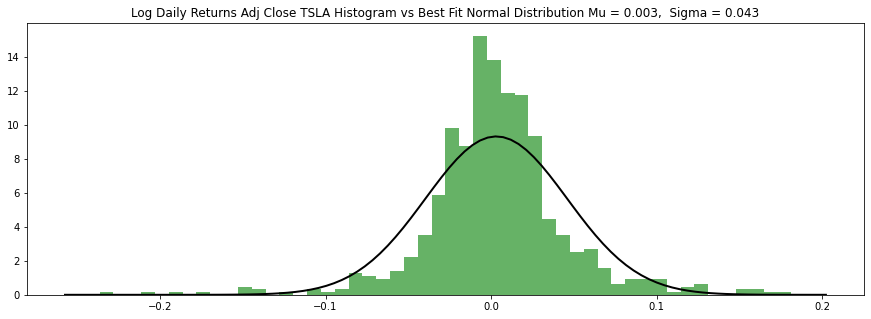

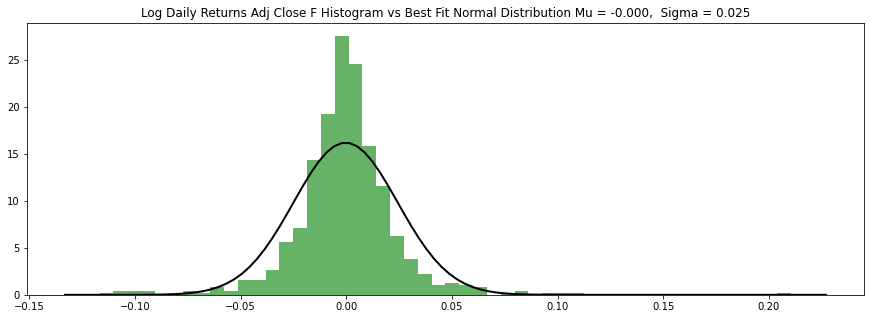

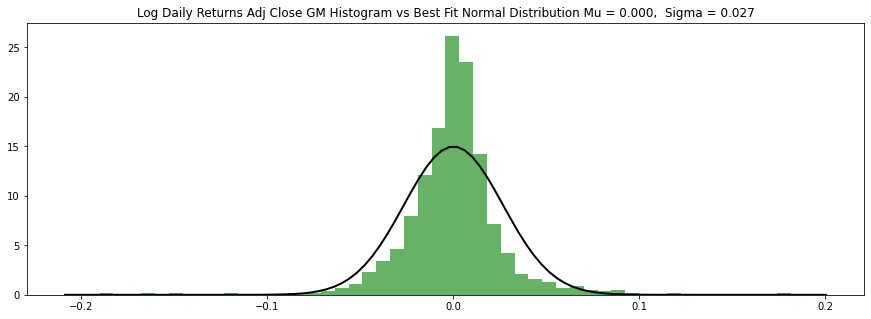

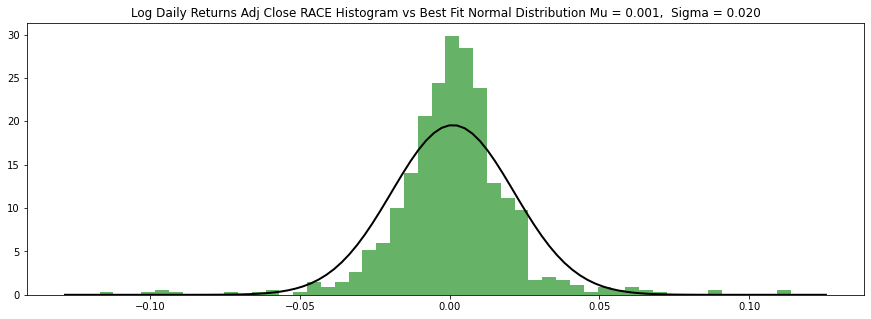

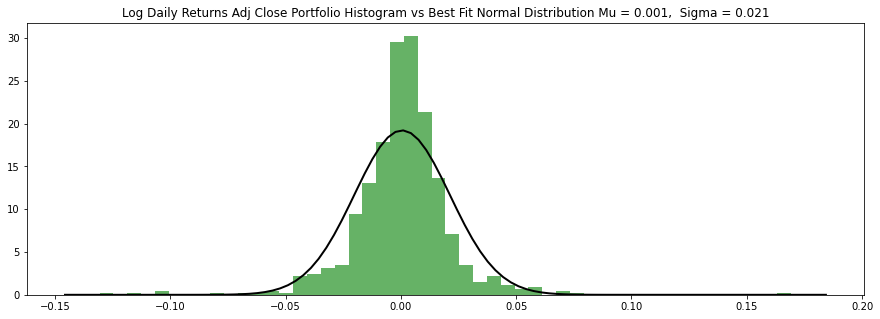

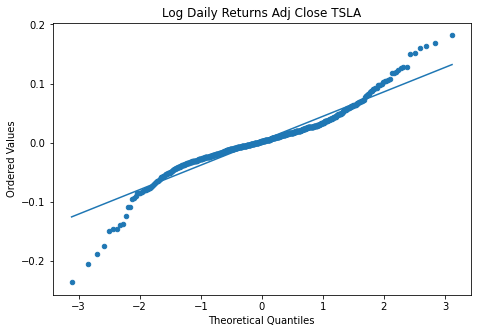

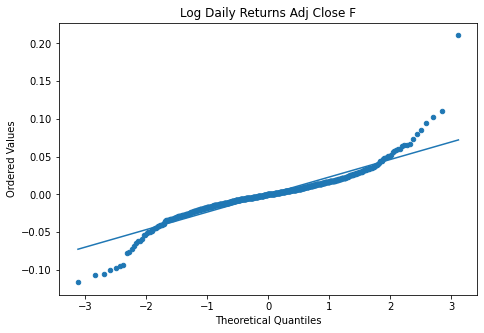

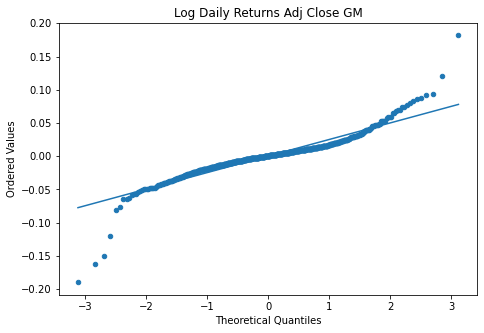

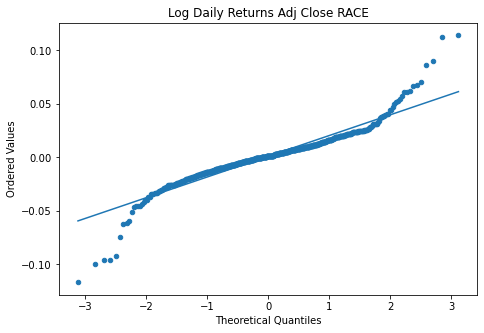

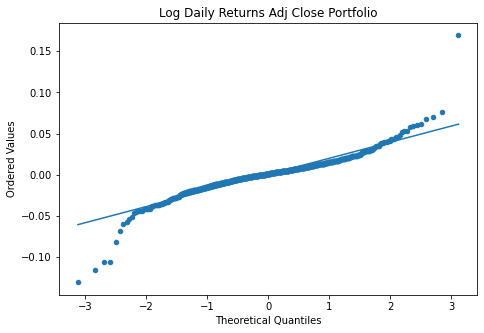

In [99]:
KSTestResultsDF, ShapiroWilkTestResultsDF , Kurtosis_Skew, ADFTestResultsDF = fit_test_normal(dfreturns,symbols,"05678","analysis")
StartMidEndMeanStdev=compareStartMidEnd(dfreturns,df_mean_stdev)


display(KSTestResultsDF)
#display(ShapiroWilkTestResultsDF)
display(Kurtosis_Skew)
display(ADFTestResultsDF)
display(StartMidEndMeanStdev.round(4))

Extracted 756 days worth of data for 4 counters with 0 missing data
Extracted 726 days worth of data for 4 counters with 0 missing data


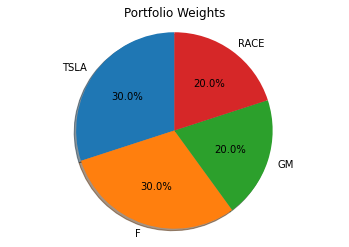

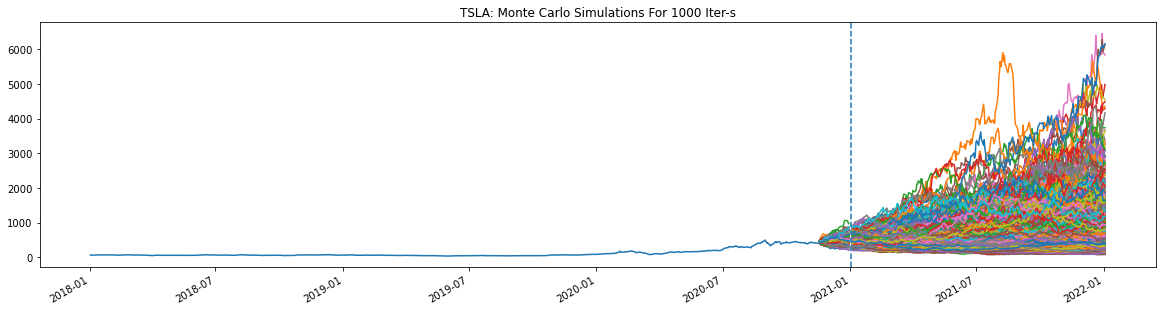

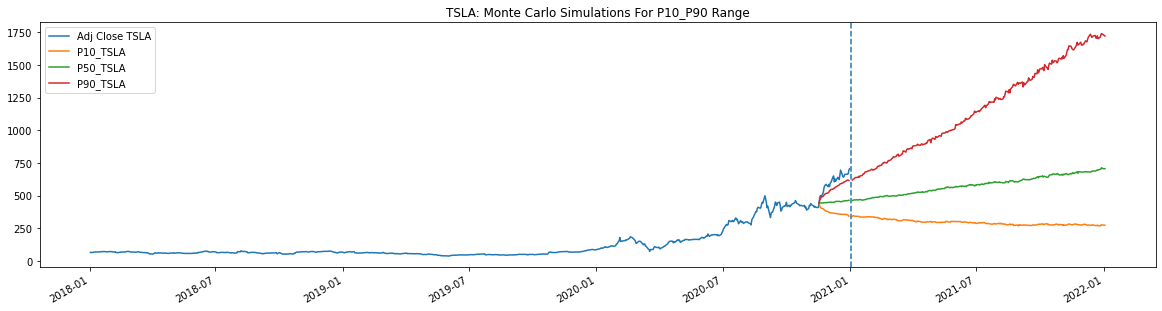

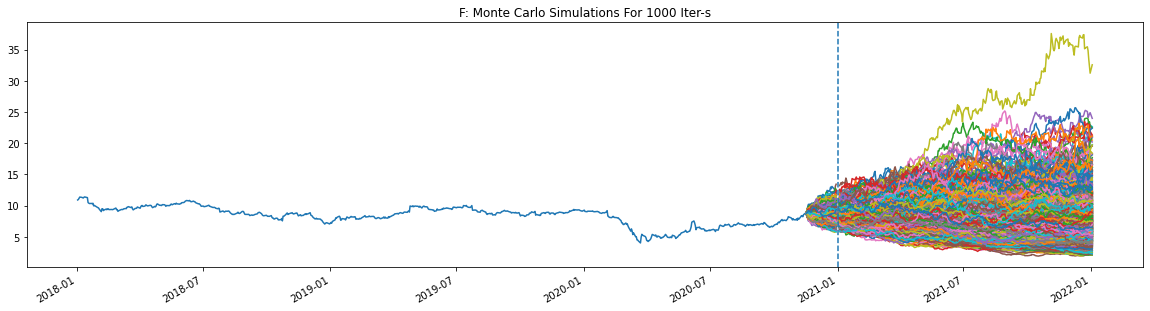

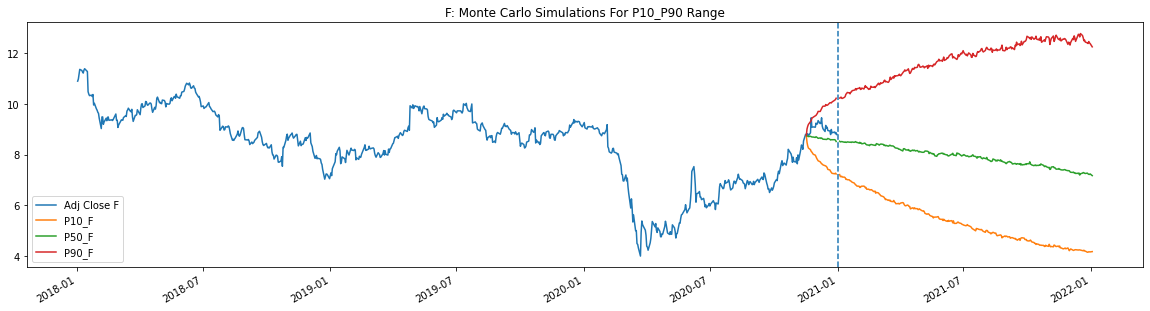

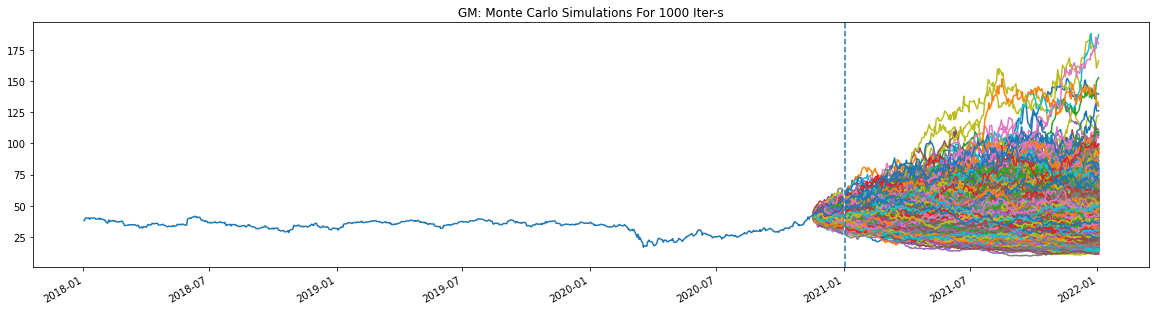

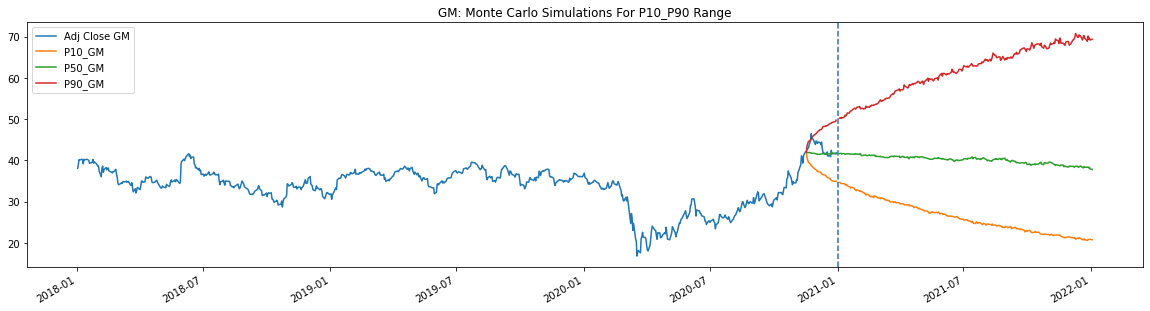

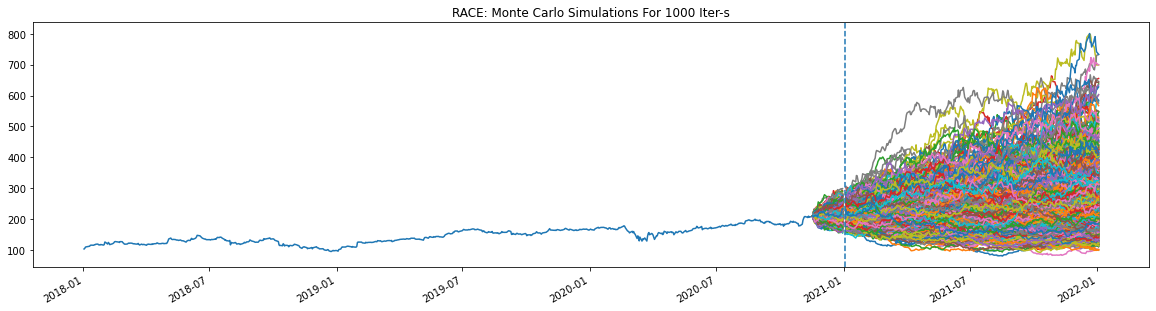

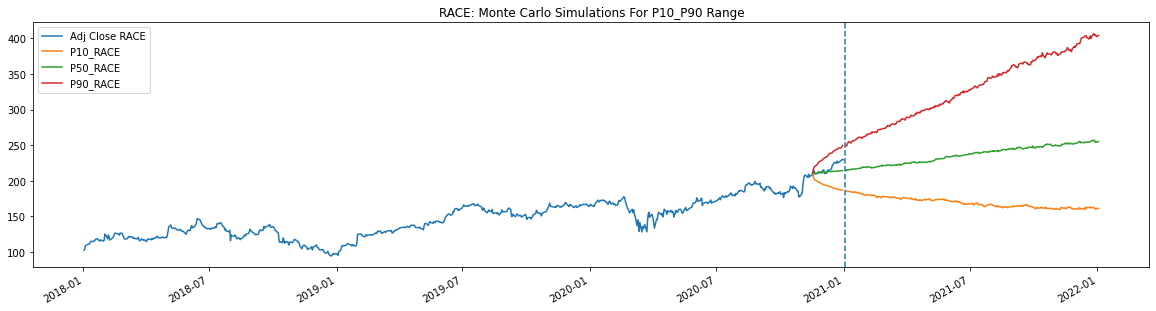

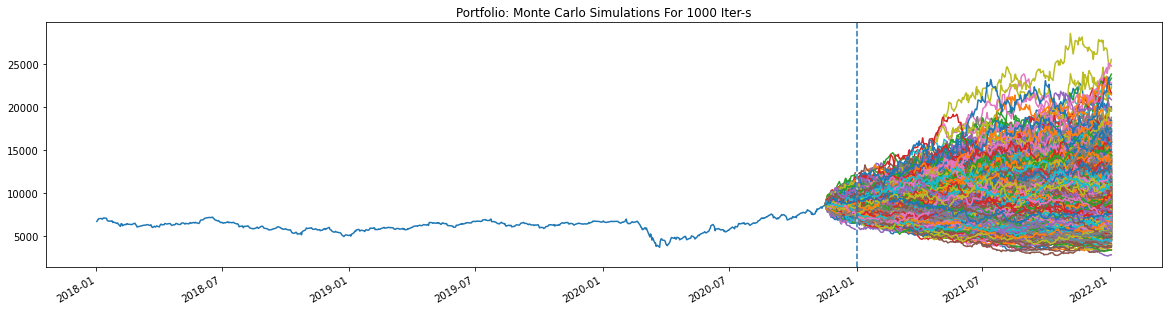

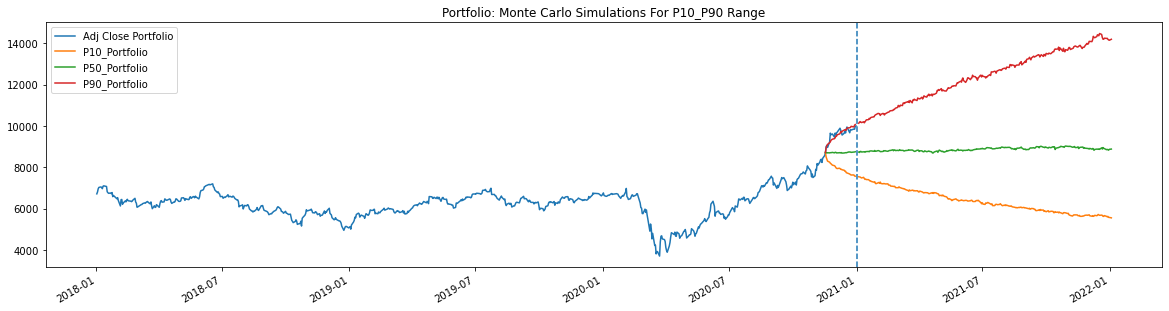

In [100]:
#MONTECARLO SIMULATION OF FUTURE PRICES
finalGBM, share_split_tableFULL , dfreturns , df_mean_stdev , ReturnsAtForecastEndDate, dfprices= MonteCarlo_GBM(start_date,end_date,backtest_duration,percentile_range,symbols,\
                       portfolioWeights,portfolioValue,T,N,NoOfIterationsMC,"GBM Simulation","efficientportfolio")

In [101]:
#1YrFutureForecast
xdfreturns_P50 ,xdf_mean_stdev_P50=calc_returns(finalGBM.tail(N-backtest_duration)[["P50_TSLA","P50_F","P50_GM","P50_RACE","P50_Portfolio"]],symbols)
display(xdf_mean_stdev_P50)

,Stock,Mean Log Daily Return,StdDev Log Daily Return
0,TSLA,0.001629,0.006108
1,F,-0.000665,0.003873
2,GM,-0.000372,0.003953
3,RACE,0.000656,0.003071
4,Portfolio,0.000064,0.003281


Optimal Sharpe Ratio: 0.059 with Weights [['TSLA:', 0.9282], ['F:', 0.0026], ['GM:', 0.0647], ['RACE:', 0.0044]]
Optimal Sortino Ratio: 0.077 with Weights [['TSLA:', 0.9282], ['F:', 0.0026], ['GM:', 0.0647], ['RACE:', 0.0044]]
Extracted 756 days worth of data for 4 counters with 0 missing data


,Stock,Mean Log Daily Return,StdDev Log Daily Return,Mean Daily Return,StdDev Daily Return
0,TSLA,0.003177,0.042892,0.003182,0.043825
1,F,-0.000284,0.024678,-0.000284,0.024985
2,GM,0.000119,0.026635,0.000119,0.026992
3,RACE,0.001065,0.020404,0.001065,0.020614
4,Portfolio,0.002524,0.034389,0.002527,0.034987


Wall time: 52.6 s


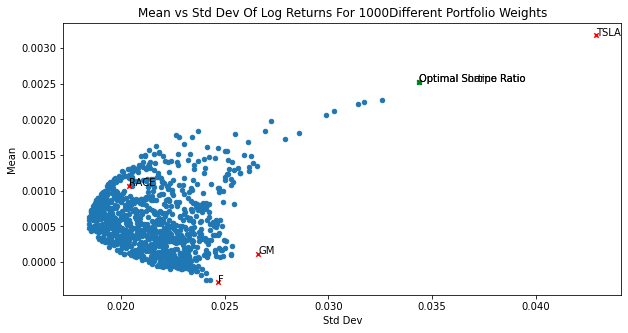

In [102]:
%%time
HistFinalResultsTable, HistSharpeDetail, HistSortinoDetail=EfficientPortfolioHistorical(start_date,end_date,symbols,portfolioValue,NoOfIterationsMC,0.12,"Historical","efficientportfolio")

HistSharpeWeights=HistFinalResultsTable.nlargest(1,['Sharpe Ratio'])['Weights'].tolist()

HistSharpe_dfprices, HistSharpe_noOfShares, HistSharpe_share_split_table = extract_prices(start_date,end_date,symbols,HistSharpeWeights[0],portfolioValue)

HistSharpe_dfreturns ,HistSharpe_df_mean_stdev=calc_returns(HistSharpe_dfprices,symbols)

HistSharpe_df_mean_stdev["Mean Daily Return"]=np.exp(HistSharpe_df_mean_stdev["Mean Log Daily Return"])-1
HistSharpe_df_mean_stdev["StdDev Daily Return"]=np.exp(HistSharpe_df_mean_stdev["StdDev Log Daily Return"])-1

display(HistSharpe_df_mean_stdev)



In [103]:
HistFinalResultsTable.nlargest(5,['Sharpe Ratio'])

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio
705,"[0.9282462397751441, 0.002615543800810676, 0.0...",0.034389,0.002524,0.059,0.077
630,"[0.6605758825370918, 0.0238040955514929, 0.040...",0.023720,0.001837,0.058,0.073
824,"[0.5752504040816077, 0.010317443083368533, 0.0...",0.022686,0.001780,0.058,0.074
93,"[0.6040552947334484, 0.0418527598667711, 0.001...",0.022806,0.001754,0.057,0.071
432,"[0.898565556005893, 0.052893737187036875, 0.03...",0.031702,0.002242,0.056,0.071


Optimal Sharpe Ratio: 0.197 with Weights [['TSLA:', 0.1467], ['F:', 0.237], ['GM:', 0.0094], ['RACE:', 0.6069]]
Optimal Sortino Ratio: 0.346 with Weights [['TSLA:', 0.1467], ['F:', 0.237], ['GM:', 0.0094], ['RACE:', 0.6069]]


"Optimal Sharpe Ratio: 0.197 with Weights [['TSLA:', 0.1467], ['F:', 0.237], ['GM:', 0.0094], ['RACE:', 0.6069]]"

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio,Components Log Returns Std Dev,Components Log Returns Mean
76,"[0.14665907966296607, 0.23701374935257563, 0.0...",0.018353,0.004082,0.197,0.346,"[0.04202403879095322, 0.0255967478275329, 0.02...","[0.007946752902214351, 0.002692768613334748, 0..."


,Mean Log Daily Return,StdDev Log Daily Return,Mean Daily Return,StdDev Daily Return
TSLA,0.007947,0.042024,0.007978,0.042920
F,0.002693,0.025597,0.002696,0.025927
GM,0.002609,0.027406,0.002613,0.027785
RACE,0.004247,0.020630,0.004256,0.020844
Portfolio,0.004082,0.018353,0.004090,0.018522


Wall time: 1min 23s


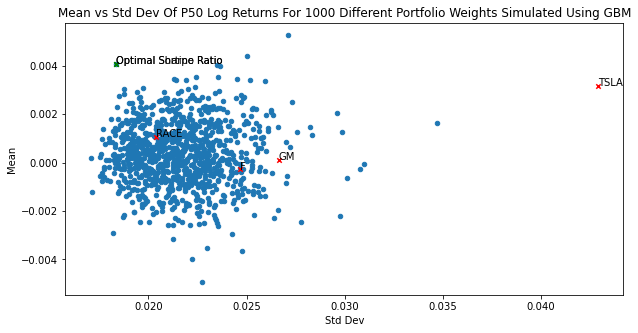

In [117]:
%%time
incorrectFutureFinalResultsTable, incorrectFutureSharpeDetail, incorrectFutureSortinoDetail = EfficientPortfolioWRONGFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,0.12,"GBM","wrongFuture","efficientportfolio")
display(incorrectFutureSharpeDetail)
display(incorrectFutureFinalResultsTable.nlargest(1,['Sharpe Ratio']))
incorrectFutureSharpeRatio_Best=pd.DataFrame(incorrectFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
incorrectFutureSharpeRatio_Best["StdDev Log Daily Return"]=incorrectFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
incorrectSharpeRatioFutureMEAN=incorrectFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Mean"].values[0]
incorrectSharpeRatioFutureSTDEV=incorrectFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Std Dev"].values[0]

incorrectFutureSharpeRatio_Best=incorrectFutureSharpeRatio_Best.append(pd.DataFrame([[incorrectSharpeRatioFutureMEAN,incorrectSharpeRatioFutureSTDEV]],index=["Portfolio"],columns=incorrectFutureSharpeRatio_Best.columns))

incorrectFutureSharpeRatio_Best["Mean Daily Return"]=np.exp(incorrectFutureSharpeRatio_Best["Mean Log Daily Return"])-1
incorrectFutureSharpeRatio_Best["StdDev Daily Return"]=np.exp(incorrectFutureSharpeRatio_Best["StdDev Log Daily Return"])-1

display(incorrectFutureSharpeRatio_Best)    

Optimal Sharpe Ratio: 0.124 with Weights [['TSLA:', 0.7883], ['F:', 0.0147], ['GM:', 0.0169], ['RACE:', 0.1801]]
Optimal Sortino Ratio: 0.206 with Weights [['TSLA:', 0.8747], ['F:', 0.0251], ['GM:', 0.0427], ['RACE:', 0.0575]]


"Optimal Sharpe Ratio: 0.124 with Weights [['TSLA:', 0.7883], ['F:', 0.0147], ['GM:', 0.0169], ['RACE:', 0.1801]]"

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio,Components Log Returns Std Dev,Components Log Returns Mean
725,"[0.7883364790564704, 0.01469519654395651, 0.01...",0.011716,0.001908,0.124,0.175,"[0.0235870267083961, 0.01098379196455054, 0.01...","[0.0024652176665278863, -0.0005613966455819318..."


,Mean Log Daily Return,StdDev Log Daily Return,Mean Daily Return,StdDev Daily Return
TSLA,0.002465,0.023587,0.002468,0.023867
F,-0.000561,0.010984,-0.000561,0.011044
GM,-0.000178,0.013306,-0.000178,0.013395
RACE,0.000877,0.009217,0.000877,0.009259
Portfolio,0.001908,0.011716,0.001909,0.011785


Wall time: 25min 34s


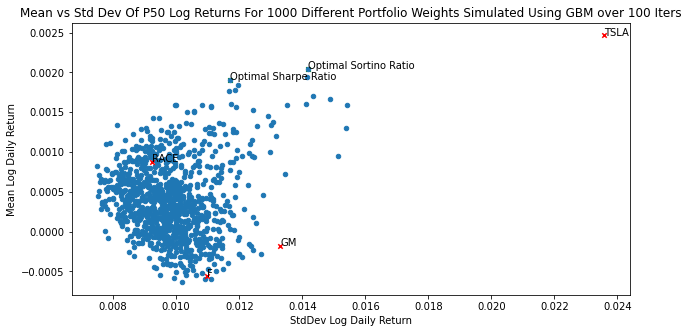

In [104]:
%%time
FutureFinalResultsTable, FutureSharpeDetail, FutureSortinoDetail =EfficientPortfolioFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,NoOfIterationsInnerLoop,0.12,"GBM","Future","efficientportfolio")
display(FutureSharpeDetail)
display(FutureFinalResultsTable.nlargest(1,['Sharpe Ratio']))
FutureSharpeRatio_Best=pd.DataFrame(FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
FutureSharpeRatio_Best["StdDev Log Daily Return"]=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
SharpeRatioFutureMEAN=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Mean"].values[0]
SharpeRatioFutureSTDEV=FutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Std Dev"].values[0]

FutureSharpeRatio_Best=FutureSharpeRatio_Best.append(pd.DataFrame([[SharpeRatioFutureMEAN,SharpeRatioFutureSTDEV]],index=["Portfolio"],columns=FutureSharpeRatio_Best.columns))

FutureSharpeRatio_Best["Mean Daily Return"]=np.exp(FutureSharpeRatio_Best["Mean Log Daily Return"])-1
FutureSharpeRatio_Best["StdDev Daily Return"]=np.exp(FutureSharpeRatio_Best["StdDev Log Daily Return"])-1

display(FutureSharpeRatio_Best)

In [105]:
FutureFinalResultsTable

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio,Components Log Returns Std Dev,Components Log Returns Mean
0,"[0.037833782371917174, 0.3432499094322357, 0.0...",0.009112,0.000256,-0.021,-0.032,"[0.019854144756162533, 0.011938939060453646, 0...","[0.002077822444810656, -0.00041914123913580224..."
1,"[0.34052215884199355, 0.42663292231955596, 0.1...",0.011398,0.000115,-0.029,-0.047,"[0.017995985842686673, 0.012216827766305316, 0...","[0.002717000746726464, -0.0007312999940776648,..."
2,"[0.33368079415945345, 0.17697273687810214, 0.0...",0.008854,0.000675,0.025,0.037,"[0.020032768892997408, 0.011816784577052781, 0...","[0.0019313109048423522, -0.0005421614325729824..."
3,"[0.6131895914709612, 0.02654892726482282, 0.07...",0.010313,0.001370,0.089,0.151,"[0.02071685497268668, 0.010975833271228171, 0....","[0.0016120123403734132, -0.0004528876263740046..."
4,"[0.5201105419559001, 0.01079692897745469, 0.00...",0.009250,0.001424,0.105,0.181,"[0.018275486120083118, 0.010708855764780029, 0...","[0.0019373528238170554, -0.0007322261814302235..."
...,...,...,...,...,...,...,...
995,"[0.16187311242009678, 0.5361304725634273, 0.00...",0.009835,0.000065,-0.039,-0.064,"[0.02034323977599613, 0.011707028577770806, 0....","[0.0021829179114704845, -0.0006634430217647949..."
996,"[0.34799192719453154, 0.00017257695319634742, ...",0.010161,0.000445,-0.000,-0.001,"[0.019877388125173118, 0.01075727877925366, 0....","[0.002510557386224676, -0.0005060560498092425,..."
997,"[0.22709504562442828, 0.12940909777821544, 0.0...",0.009105,0.000799,0.038,0.069,"[0.019767649945840918, 0.011440066657526865, 0...","[0.002027166035716144, -0.0005719118285500566,..."
998,"[0.1598676822975702, 0.21411744612412875, 0.07...",0.008421,0.000444,-0.001,-0.001,"[0.022041990719758833, 0.011908112195920691, 0...","[0.001975467421884717, -0.0007029460866425588,..."


Optimal Sharpe Ratio: 1.025 with Weights [['TSLA:', 0.4657], ['F:', 0.0162], ['GM:', 0.2893], ['RACE:', 0.2288]]
Optimal Sortino Ratio: 0.631 with Weights [['TSLA:', 0.8705], ['F:', 0.0149], ['GM:', 0.0409], ['RACE:', 0.0738]]


"Optimal Sharpe Ratio: 1.025 with Weights [['TSLA:', 0.4657], ['F:', 0.0162], ['GM:', 0.2893], ['RACE:', 0.2288]]"

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio,Components Log Returns Std Dev,Components Log Returns Mean
958,"[0.4657217457637164, 0.01620764680445416, 0.28...",0.001536,0.002023,1.025,0.524,"[0.0038402167032525777, 0.0017692030181657385,...","[0.0023361994566974856, -0.0003171395034211775..."


,Mean Log Daily Return,StdDev Log Daily Return,Mean Daily Return,StdDev Daily Return
TSLA,0.002336,0.003840,0.002339,0.003848
F,-0.000317,0.001769,-0.000317,0.001771
GM,0.000311,0.001893,0.000311,0.001895
RACE,0.001282,0.001629,0.001283,0.001630
Portfolio,0.002023,0.001536,0.002025,0.001537


Wall time: 1h 40min 47s


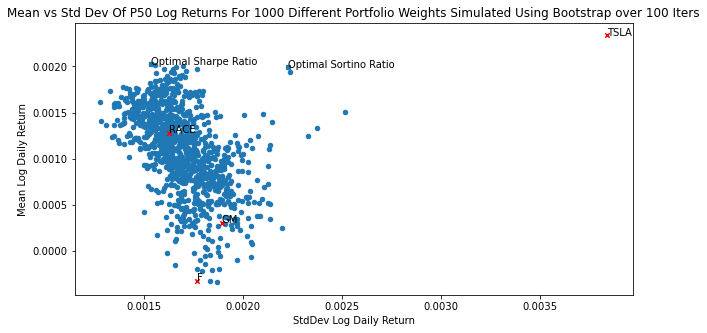

In [106]:
#Demonstration of Bootstrap vs GBM simulation for future returns
%%time
xFutureFinalResultsTable, xFutureSharpeDetail, xFutureSortinoDetail =EfficientPortfolioFuture(start_date,end_date,symbols,portfolioValue,T,N,NoOfIterationsMC,NoOfIterationsInnerLoop,0.12,"Bootstrap","xFuture","efficientportfolio")
display(xFutureSharpeDetail)
display(xFutureFinalResultsTable.nlargest(1,['Sharpe Ratio']))
xFutureSharpeRatio_Best=pd.DataFrame(xFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Mean"].values[0],index=symbols,columns=["Mean Log Daily Return"])
xFutureSharpeRatio_Best["StdDev Log Daily Return"]=xFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Components Log Returns Std Dev"].values[0]
xSharpeRatioFutureMEAN=xFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Mean"].values[0]
xSharpeRatioFutureSTDEV=xFutureFinalResultsTable.nlargest(1,['Sharpe Ratio'])["Log Returns Std Dev"].values[0]

xFutureSharpeRatio_Best=xFutureSharpeRatio_Best.append(pd.DataFrame([[xSharpeRatioFutureMEAN,xSharpeRatioFutureSTDEV]],index=["Portfolio"],columns=xFutureSharpeRatio_Best.columns))

xFutureSharpeRatio_Best["Mean Daily Return"]=np.exp(xFutureSharpeRatio_Best["Mean Log Daily Return"])-1
xFutureSharpeRatio_Best["StdDev Daily Return"]=np.exp(xFutureSharpeRatio_Best["StdDev Log Daily Return"])-1

display(xFutureSharpeRatio_Best)

In [107]:
xFutureFinalResultsTable

,Weights,Log Returns Std Dev,Log Returns Mean,Sharpe Ratio,Sortino Ratio,Components Log Returns Std Dev,Components Log Returns Mean
0,"[0.6950467706296286, 0.15861063667753436, 0.09...",0.001672,0.000965,0.308,0.152,"[0.0036961084563415093, 0.0017996073527835527,...","[0.002247273409309157, -0.00024061664434145812..."
1,"[0.6067095751522824, 0.11100731676349078, 0.20...",0.001831,0.001313,0.472,0.275,"[0.00370380900682378, 0.0018051203105066264, 0...","[0.002085352518809952, -0.0002140678172819198,..."
2,"[0.33360867918903375, 0.22987800578873255, 0.2...",0.001699,0.001147,0.410,0.201,"[0.003528661067704198, 0.0019281502334801458, ...","[0.0021409916399067674, -0.0005681928811199987..."
3,"[0.3768065484870435, 0.011438538282294084, 0.5...",0.001798,0.001098,0.361,0.166,"[0.003770097402769503, 0.00195326820410613, 0....","[0.002212931704981248, -0.00034691104548445446..."
4,"[0.01833145365947668, 0.14893687325802524, 0.6...",0.001975,0.000716,0.135,0.079,"[0.0034682059652789096, 0.0019308037594399868,...","[0.0014922203807743787, -0.0002217589457069101..."
...,...,...,...,...,...,...,...
995,"[0.13638779085364272, 0.18922548147803164, 0.0...",0.001386,0.001669,0.880,0.430,"[0.003469231646701036, 0.001821291417604175, 0...","[0.0019338461716879483, -0.0002021424977145746..."
996,"[0.02736553986110568, 0.3332242626580649, 0.46...",0.002106,0.000691,0.115,0.063,"[0.0036962379968730635, 0.001977581698693434, ...","[0.0024904940888602588, -0.0002921026905269099..."
997,"[0.2827388855250922, 0.1234998441331911, 0.165...",0.001501,0.001643,0.795,0.381,"[0.0034219741776443918, 0.0018722627820360516,...","[0.002273598928879476, -0.00027016945308250674..."
998,"[0.23607610622763892, 0.2561181245579957, 0.18...",0.001581,0.001466,0.643,0.396,"[0.003192051095622022, 0.0017328018147464567, ...","[0.0018978869241781167, -0.0001730353563854719..."
